In [1]:
%%capture capt
!pip install matplotlib torchsummary scikit-learn pandas
!pip install -U imbalanced-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from torchsummary import summary

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
from gilbert2d import gilbert2d

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model running on {device}.")

Model running on cuda.


## Data Loading

In [4]:
CLASSES = ["asymetric", "banded", "locked", "butterfly", "no_pattern"]

In [5]:
# Mapping int to categories
int_to_cat = {
    0: "asymetric",
    1: "banded",
    2: "locked",
    3: "butterfly",
    4: "no_pattern",
}

In [6]:
X_train = np.load("./data/X_train.npy")
y_train_df = pd.read_csv("./data/y_train.csv")

In [7]:
X_test = np.load("./data/X_test.npy")
y_test_df = pd.read_csv("./data/y_test.csv")

## SMOTE

In [8]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, SVMSMOTE

In [9]:
def smote_X(X, y, method=None, k_neighbors=5, m_neighbors=10):
    if method is None or method=='None':
        return X, y
    if method == 'standard':
        sm = SMOTE(k_neighbors=k_neighbors)
    if method == 'KMeans':
        sm = KMeansSMOTE(k_neighbors=k_neighbors)
    if method == 'SVM':
        sm = SVMSMOTE(k_neighbors=k_neighbors, m_neighbors=m_neighbors)

    length, nrows, ncols = X.shape
    X = X.reshape(length, -1)
    X, y = sm.fit_resample(X, y)
    X = X.reshape(-1, nrows, ncols)
    return X, y

## Flatten with Peano curve

In [10]:
def flatten_peano(X):
    peano_indices = np.array(list(gilbert2d(X[0].shape[0], X[0].shape[1])))
    flat_indices = X[0].shape[1] * peano_indices[:, 0] + peano_indices[:, 1]
    return X.reshape(-1, X[0].shape[0]*X[0].shape[1])[:, flat_indices]

In [11]:
def max_pool(img, factor=2):
    """ Perform max pooling with a (factor x factor) kernel"""
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

In [12]:
def black_and_white(X):
    return np.where(X > 0.5, 1, 0)

In [13]:
def flatten(X_train, X_test, max_pool_factor=2, bw=False, peano=True):
    if bw:
        X_train = black_and_white(X_train)
        X_test = black_and_white(X_test)

    vectorized_max_pool = np.vectorize(lambda x: max_pool(x, max_pool_factor), signature='(m,n)->(k,l)')
    if peano:
        flattened_img_train = flatten_peano(vectorized_max_pool(X_train))
        flattened_img_test = flatten_peano(vectorized_max_pool(X_test))
    else:
        flattened_img_train = X_train.reshape(len(X_train), -1)
        flattened_img_test = X_test.reshape(len(X_test), -1)
    return flattened_img_train, flattened_img_test

In [14]:
def get_X_train_test(X_train, y_train_df, X_test, y_test_df,
                    method='standard', k_neighbors=5, m_neighbors=10,
                    max_pool_factor=2, bw=False, peano=True):
    
    X_train, y_train = smote_X(X_train, y_train_df.cat_num.values, method=method, k_neighbors=k_neighbors, m_neighbors=m_neighbors)
    flattened_img_train, flattened_img_test = flatten(X_train, X_test, max_pool_factor=max_pool_factor, bw=bw, peano=peano)
    
    return flattened_img_train, y_train, flattened_img_test, y_test_df.cat_num.values

# Train model

In [15]:
%%capture capt
!pip install optuna

In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score

In [32]:
def objective_(trial, X_train, y_train, X_test, y_test):
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, step=1e-1)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100, step=10)
    max_depth_none = trial.suggest_categorical('max_depth_none', [False, True])
    if max_depth_none:
        max_depth = trial.suggest_int('max_depth', 5, 150, step=5)
    else:
        max_depth = None
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 5, 20, step=5)
    l2_regularization = trial.suggest_float('l2_regularization', 0, 1, step=0.2)
    

    hgb_classifier = HistGradientBoostingClassifier(learning_rate=learning_rate, max_iter=500, max_leaf_nodes=max_leaf_nodes, max_depth=max_depth,
                                                  min_samples_leaf=min_samples_leaf, early_stopping=True, validation_fraction=0.15, n_iter_no_change=3,
                                                  class_weight='balanced')
    hgb_classifier.fit(X_train, y_train)
    y_pred = hgb_classifier.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred)
    return score

In [33]:
def optuna_study(X_train, y_train_df, X_test, y_test_df,
                    method='standard', k_neighbors=5, m_neighbors=10,
                    max_pool_factor=2, bw=False, peano=True):
    
    X_train, y_train, X_test, y_test = get_X_train_test(X_train, y_train_df, X_test, y_test_df, method=method, k_neighbors=k_neighbors,
                                                       m_neighbors=m_neighbors, max_pool_factor=max_pool_factor, bw=bw, peano=peano)
    study_name = f'./hgb_optuna/HGB_{method}, k_neigh{k_neighbors}, m_neigh{m_neighbors}, pool{max_pool_factor}_bw{bw}_peano{peano}'
    print(study_name)
    study = optuna.create_study(direction = 'maximize', study_name=study_name, load_if_exists=True)
    def objective(trial):
        return objective_(trial, X_train, y_train, X_test, y_test)
    study.optimize(objective, n_trials=500, show_progress_bar=True)
    return study

In [34]:
methods = ['standard', 'KMeans']#, 'SVM']
k_neighborss = [2, 5, 15, 20]
max_pool_factors = [1, 2, 3, 5]
bws = [False, True]
peanos = [True, False]

In [35]:
res = {}
for method in methods:
    for k_neighbor in k_neighborss:
        for max_pool_factor in max_pool_factors:
            for bw in bws:
                for peano in peanos:
                    res[f'{method}_kneigh:{k_neighbor}_pool:{max_pool_factor}_bw:{bw}_peano:{peano}'] = -1
for max_pool_factor in max_pool_factors:
    for bw in bws:
        for peano in peanos:
            res[f'{None}_pool:{max_pool_factor}_bw:{bw}_peano:{peano}'] = -1

In [36]:
keys_to_try = np.array(list(res.keys()))
np.random.shuffle(keys_to_try)
len(keys_to_try)

144

In [37]:
def get_args(key):
    def left_val(arg):
        return arg.split(":")[1]
    args = key.split("_")
    method = args[0]
    if len(args) == 5:
        k_neighbors = int(left_val(args[1]))
        max_pool_factor = int(left_val(args[2]))
        bw = bool(left_val(args[3]))
        peano = bool(left_val(args[4]))
        return method, k_neighbors, max_pool_factor, bw, peano
    max_pool_factor = int(left_val(args[1]))
    bw = bool(left_val(args[2]))
    peano = bool(left_val(args[3]))
    return method, max_pool_factor, bw, peano

In [ ]:
import pickle

for key in keys_to_try:
    if res[key] != -1:
        pass
    else:
        print(key)
        args = get_args(key)
        if len(args) == 5:
            method, k_neighbors, max_pool_factor, bw, peano = args
        else:
            method, max_pool_factor, bw, peano = args
            k_neighbors=5
        study = optuna_study(X_train, y_train_df, X_test, y_test_df,
                        method=method, k_neighbors=k_neighbors, m_neighbors=10,
                        max_pool_factor=max_pool_factor, bw=bw, peano=peano)
        best_trial = study.best_trial
        best_score = best_trial.value
        best_params = best_trial.params
        res[key] = [best_score, study, best_params]
        with open('hgb_res.pkl', 'wb') as f:
            pickle.dump(res, f)

KMeans_kneigh:15_pool:3_bw:False_peano:True


/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/opt/mamba/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitl

./hgb_optuna/HGB_KMeans, k_neigh15, m_neigh10, pool3_bwTrue_peanoTrue


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/mamba/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.001, 0.1] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.001, 0.001].
  warnings.warn(


### Scores

In [20]:
%%capture capt
y_pred = est.predict(X_test.cpu())
y_pred_train = est.predict(X_train.cpu())

In [21]:
print(balanced_accuracy_score(y_pred, y_test.cpu()), accuracy_score(y_pred, y_test.cpu()))
balanced_accuracy_score(y_pred_train, y_train.cpu()), accuracy_score(y_pred_train, y_train.cpu())

0.638888888888889 0.7058823529411765


/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(0.9819808687412304, 0.9819927971188476)

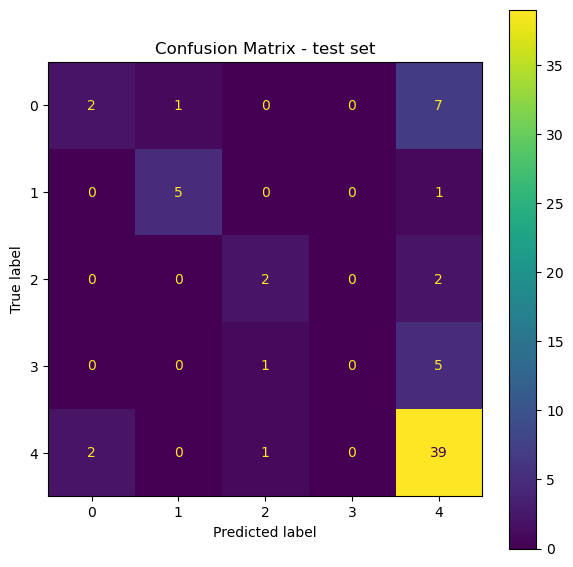

In [22]:
disp = ConfusionMatrixDisplay.from_predictions(y_test.cpu(), y_pred)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)  
plt.title("Confusion Matrix - test set");

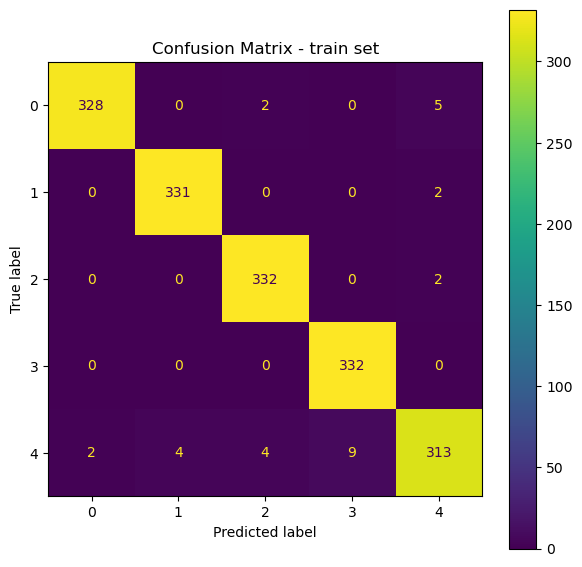

In [23]:
disp = ConfusionMatrixDisplay.from_predictions(y_train.cpu(), y_pred_train)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)  
plt.title("Confusion Matrix - train set");

## Ramp

In [77]:
class Classifier():
    def __init__(self):
        self.model = model

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y

    def predict(self, X):
        return

    def predict_proba(self, X):
        # Create an array of zeros
        y_pred = np.zeros((X.shape[0], 5), dtype=int)
        # Set one random index per row to 1
        for i in range(X.shape[0]):
            random_index = random.randint(0, 4)
            y_pred[i, random_index] = 1
        return np.array(y_pred)

In [78]:
!ramp-test --submission starting_kit

Testing Hot Jupiter atmospheric pattern classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train      0.2  0.535  0.009778
	valid      0.2  0.537  0.000182
	test       0.2  0.618  0.000020
CV fold 1
	score  bal_acc    acc      time
	train      0.2  0.598  0.009918
	valid      0.2  0.390  0.000166
	test       0.2  0.618  0.000019
CV fold 2
	score  bal_acc    acc      time
	train      0.2  0.467  0.008288
	valid      0.2  0.652  0.000162
	test       0.2  0.618  0.000019
----------------------------
Mean CV scores
----------------------------
	score    bal_acc             acc       time
	train  0.2 ± 0.0  0.533 ± 0.0537  0.0 ± 0.0
	valid  0.2 ± 0.0  0.526 ± 0.1071  0.0 ± 0.0
	test   0.2 ± 0.0     0.618 ± 0.0  0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid      0.2  0.535
	test       0.2  0.618
